In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_selected = pd.read_csv('data/rusentiment/rusentiment_preselected_posts.csv')
df_random = pd.read_csv('data/rusentiment/rusentiment_random_posts.csv')
df_test = pd.read_csv('data/rusentiment/rusentiment_test.csv')

In [3]:
print(f'Preselected length:{len(df_selected)}')
print(f'Random length:{len(df_random)}')
print(f'Test length:{len(df_test)}')

Preselected length:6950
Random length:21268
Test length:2967


In [4]:
df_selected['label'].value_counts()

neutral     2977
positive    1475
negative    1360
skip         904
speech       234
Name: label, dtype: int64

In [5]:
df_random['label'].value_counts()

neutral     8323
positive    4635
skip        3190
speech      2826
negative    2294
Name: label, dtype: int64

In [6]:
df_test['label'].value_counts()

neutral     1420
positive     536
speech       407
skip         346
negative     258
Name: label, dtype: int64

In [7]:
df_train = pd.concat((df_selected, df_random))

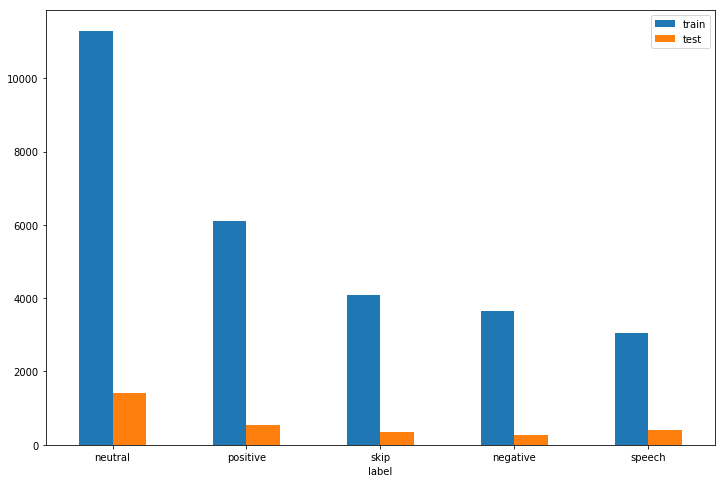

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'train': df_train.groupby('label').text.count(), 'test':df_test.groupby('label').text.count()})
freq.sort_values(by='train', ascending=False).plot.bar(rot=0, ax=ax);

In [9]:
# Original code https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py
from ufal.udpipe import Model, Pipeline

#! wget http://rusvectores.org/static/models/udpipe_syntagrus.model
udpipe_filename = 'udpipe_syntagrus.model'
model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

def tag_ud(pipeline, text='Text in string format', pos=True):
    # если частеречные тэги не нужны (например, их нет в модели), выставьте pos=False
    # в этом случае на выход будут поданы только леммы

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста лемму и тэг
    tagged = [w.split('\t')[2].lower() + '_' + w.split('\t')[3] for w in content if w]
    result = []
    for t in tagged:
        if (len(t.split('_')) == 2):
            lemma, tag = t.split('_')
            # убираем числительные и все знаки пунктуации кроме скобок
            if tag == 'NUM' or (tag == 'PUNCT' and lemma not in ['(', ')']):
                continue
            if pos:
                result.append(lemma + '_' + tag)
            else:
                result.append(lemma)
    return result

df_train['lemmatized_tokens'] = df_train.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)
df_test['lemmatized_tokens'] = df_test.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)

df_train['lemmatized_text'] = df_train['lemmatized_tokens'].str.join(' ')
df_test['lemmatized_text'] = df_test['lemmatized_tokens'].str.join(' ')

df_train = df_train[~df_train.lemmatized_text.isnull()]
df_test = df_test[~df_test.lemmatized_text.isnull()]

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_train = df_train['lemmatized_text'].values
X_test = df_test['lemmatized_text'].values

y_train  = le.fit_transform(df_train['label'].values)
y_test  = le.transform(df_test['label'].values) 

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.stats import expon

k = 5
skf = StratifiedKFold(n_splits=k, random_state=42)

# svc_pipeline = Pipeline([('tfidf',TfidfVectorizer()), ('svc', LinearSVC(penalty='l1', dual=False))])

# C_distr = expon(scale=2)
# param_grid = {'tfidf__ngram_range':[(1,1),(1,2)],
#               'tfidf__sublinear_tf':[True, False],
#               'svc__C': C_distr}

# grid = RandomizedSearchCV(svc_pipeline, param_grid, n_iter=10, scoring='f1_macro', cv=skf, n_jobs=-1)
# grid_model = grid.fit(X_train, y_train)
# grid_model.best_params_

best_svc_pipeline = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,1), sublinear_tf=False)),
                              ('svc', LinearSVC(C=0.624, penalty='l1', dual=False))])

precision = cross_val_score(best_svc_pipeline, X_train, y_train, cv=skf, scoring='precision_weighted', n_jobs=-1)
print(f'Precision {k}-folds mean:{np.mean(precision):.4f}')
recall = cross_val_score(best_svc_pipeline, X_train, y_train, cv=skf, scoring='recall_weighted', n_jobs=-1)
print(f'Recall {k}-folds mean:{np.mean(recall):.4f}')
f1_score = cross_val_score(best_svc_pipeline, X_train, y_train, cv=skf, scoring='f1_weighted', n_jobs=-1)
print(f'f1-score {k}-folds mean:{np.mean(f1_score):.4f}')

Precision 5-folds mean:0.5995
Recall 5-folds mean:0.5977
f1-score 5-folds mean:0.5706


In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

best_svc_pipeline.fit(X_train, y_train)
y_pred = best_svc_pipeline.predict(X_test)
def score_model(y_pred, y_true):
    average = 'weighted'
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

f1, precision, recall = score_model(y_pred,y_test)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1-score: {f1:.4f}')

Precision: 0.6748
Recall: 0.6896
f1-score: 0.6702


/home/nerdikon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


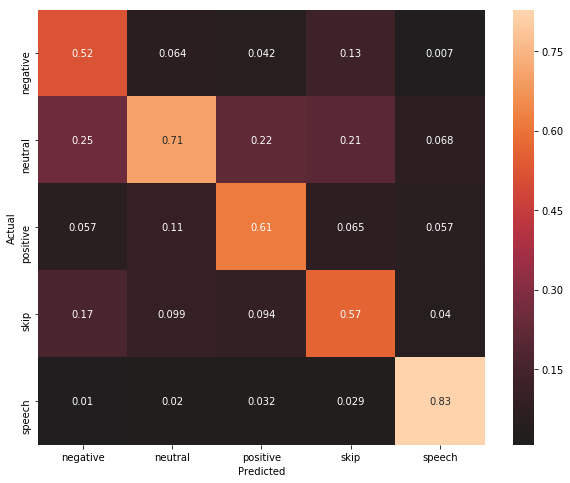

In [13]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_ratios = np.round(conf_mat / np.sum(conf_mat, axis=0),3)
fig, ax = plt.subplots(figsize=(10,8))

labels = sorted(list(set(le.inverse_transform(y_pred))))
sns.heatmap(conf_mat_ratios, annot=True, center=0, xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

results = pd.DataFrame({'text':df_test.text, 'lemmatized_tokens':df_test.lemmatized_tokens,'predicted':y_pred_labels, 'actual':y_test_labels})
errors = results[results.predicted != results.actual]

/home/nerdikon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nerdikon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


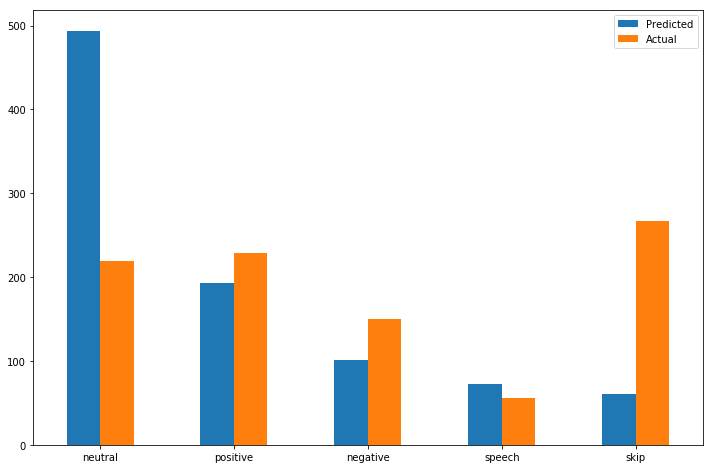

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'Predicted': errors.predicted.value_counts(), 'Actual':errors.actual.value_counts()})
freq.sort_values(by='Predicted', ascending=False).plot.bar(rot=0, ax=ax);

In [16]:
errors

,text,lemmatized_tokens,predicted,actual
3,Мы просто с [id12210212|Елисеем] психанули )...,"[мы, просто, с, id12210212|елисей, психануть, ...",positive,skip
11,Селфи дня )),"[селфи, день, ), )]",neutral,positive
17,"Я не писал такое оскобление всем!!!!\nМеня, ви...","[я, не, писать, такой, оскоблений, все, я, вид...",neutral,skip
18,...и так начало мини отпуска))И новых приключе...,"[...ь, так, начинать, минять, отпуск, ), ), и,...",neutral,positive
19,Кинул в чс обиделся холоп понял что недостоин ...,"[кидать, в, чс, обижаться, холоп, понимать, чт...",neutral,negative
21,Лучше бы у Тани не было никакого оргазма: услы...,"[хороший, бы, в, таня, не, быть, никакой, орга...",neutral,skip
25,"по кругу, твою подругу КСЮХУ....))))))ахахахаахах","[по, круг, твой, подруга, ксюх, ), ), ), ), ),...",neutral,skip
26,без тебя_(,"[без, (]",neutral,negative
27,я прыгнул в бездну из уюта пора готовиться к з...,"[я, прыгнуть, в, бездна, из, уют, пора, готови...",neutral,negative
29,"амммм, Каринка)))","[амммма, каринк, ), ), )]",neutral,skip


In [ ]:
Without POS

best_svc_pipeline = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,1), sublinear_tf=False)), ('svc', LinearSVC(C=0.6235, penalty='l1', dual=False))])
Precision: 0.6748
Recall: 0.6896
f1-score: 0.6702

Witg POS
best_svc_pipeline = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,1), sublinear_tf=False)), ('svc', LinearSVC(C=0.5, penalty='l1', dual=False))])
Precision: 0.6678
Recall: 0.6781
f1-score: 0.6606